In [1]:
import pandas as pd
import numpy as np
import string
import nltk
import math
import matplotlib.pyplot as plt

from nltk.corpus import stopwords,wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,f1_score,accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.multiclass import OneVsRestClassifier

# Imbalance parameter
sample_to_rating = 3 # 1-5 


nltk.download('stopwords')
nltk.download('wordnet')
# disable warnings
pd.options.mode.chained_assignment = None  # default='warn'

df = pd.read_csv('data\Womens Clothing E-Commerce Reviews.csv', delimiter=',')
df.head(5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Yahya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Yahya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


C:\Users\Yahya\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rating'>

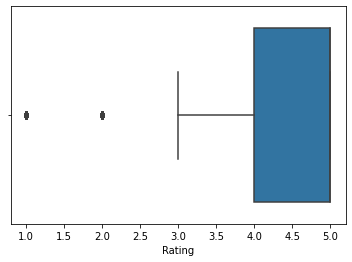

In [2]:
import seaborn as sns
sns.boxplot(df['Rating'])

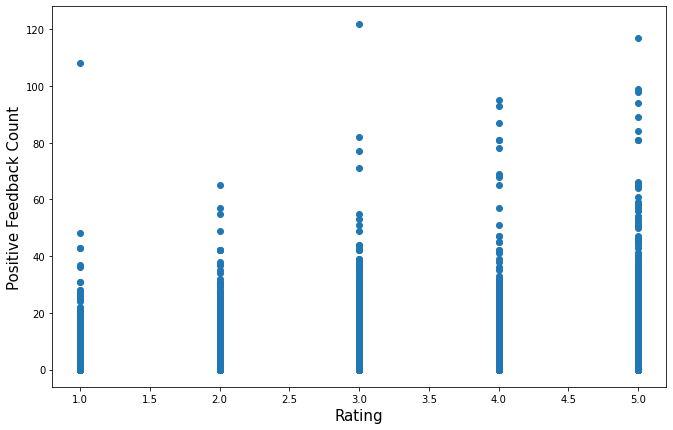

In [3]:
fig, ax = plt.subplots(figsize = (11,7))
ax.scatter(df['Rating'], df['Positive Feedback Count'])
# x-axis label
ax.set_xlabel('Rating', fontsize=15)
 
# y-axis label
ax.set_ylabel('Positive Feedback Count', fontsize=15)
plt.show()

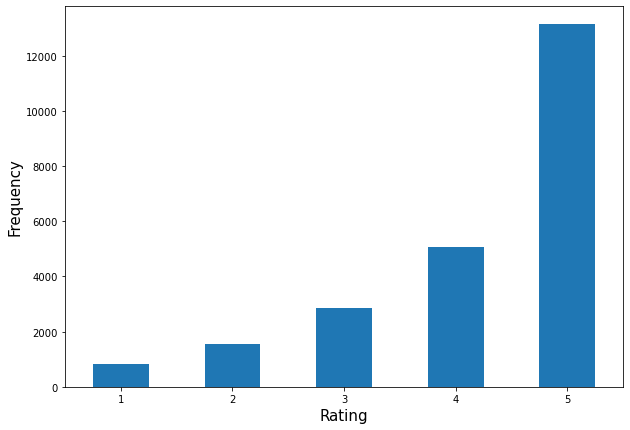

In [4]:
fig, ax = plt.subplots(figsize = (10,7))
df.Rating.value_counts().sort_index(ascending=True).plot(ax=ax, kind='bar', rot=0)
# x-axis label
ax.set_xlabel('Rating', fontsize=15)
 
# y-axis label
ax.set_ylabel('Frequency', fontsize=15)
plt.show()

In [5]:
df.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [7]:
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

def tokenizing(text):
    #Creating a list of tokens of the text
    tokenizer = TweetTokenizer()
    tokenizedText = tokenizer.tokenize(text)
    return tokenizedText

def cleaning(text):
    output =" "
    tokenizedText = tokenizing(text)

    #Removing any punctuation except apostrophe, (commas?)
    rpTokens=[]
    punctuation = string.punctuation.replace("'","")
    punctuation = punctuation.replace("-","")

    punctuationMapping = str.maketrans('', '', punctuation)
    for i in tokenizedText:
        if i!="br":
            noPuncWord = i.translate(punctuationMapping)
            rpTokens.append(noPuncWord)

    #Removing numbers from the tokens list 
    tempTokens=[]
    for i in rpTokens:
        if i.isalpha():
            tempTokens.append(i)
        elif ("'" in i) and (len(i)>1):
            tempTokens.append(i)
        elif i.isnumeric():
            tempTokens.append(i)
        elif "-" in i:
            tempTokens.append(i.replace("-", " "))



    return output.join(tempTokens)

def lemmatizing(text):
    output =" "
    tokenizedText = tokenizing(text)
    
    #Lowercasing
    lcTokens=[]
    for i in tokenizedText:
        lcTokens.append(i.lower())

    #Removing the stop words 
    stop_words = set(stopwords.words('english'))
    swTokens=[]
    for i in lcTokens:
        if not i in stop_words:
            swTokens.append(i)

    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatizedTokens=[]
    for i in swTokens:
        lemma=lemmatizer.lemmatize(i)
        if "'" in lemma:
            if lemma in contractions.keys():
                lemma = lemma.replace(lemma, contractions[lemma])
                temp = lemma.split(" ")
                temp = list(dict.fromkeys(temp))
                for y in temp:
                    if y.isalpha():
                        lemmatizedTokens.append(y.lower())
            else:
                #empty string or space?
                temp = lemma.replace("'",'')
                lemmatizedTokens.append(temp)
        else:
            lemmatizedTokens.append(lemma)
    
    #Removing the stop words 
    swTokensTemp=[]
    for i in lemmatizedTokens:
        if not i in stop_words:
            swTokensTemp.append(i)
    #print(len(lemmatizedTokens))
    #print(len(swTokens))
    #print(lemmatizedTokens)

    return output.join(swTokensTemp)


def preprocessingText(text):
    result = cleaning(text)
    finalResult = lemmatizing(result)
    return finalResult    

all_models=[]

In [8]:
# df = df[df['Positive Feedback Count'] < 30]

In [9]:
# raw_df.dropna(inplace=True)
raw_df = df[df['Review Text'].notna()]
# raw_df.reset_index(drop=True, inplace=True)
raw_df.drop(["Clothing ID","Unnamed: 0","Department Name","Division Name" ], axis=1, inplace=True)
# raw_df['Word Count']=pd.NaT
raw_df.head()

,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Class Name
0,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimates
1,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses
2,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses
3,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Pants
4,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Blouses


In [10]:
reviews=[]
titles=[]
classes=[]

for i,row in raw_df.iterrows():
    # result={}
    review_text=raw_df['Review Text'][i]
    title_text=raw_df['Title'][i]
    class_text=raw_df["Class Name"][i]

    if type(class_text)==str and len(class_text)>0:
        processed_class=class_text.lower()
        classes.append(processed_class)
    else:
        classes.append("")

    if type(title_text)==str and len(title_text)>0:
        processed_title=preprocessingText(title_text)
        titles.append(processed_title)
    else:
        titles.append("")

    if type(review_text)==str and len(review_text)>0:
        processed_text=preprocessingText(review_text)
        reviews.append(processed_text)
    else:
        reviews.append("")


raw_df['review']=reviews
raw_df.drop(["Review Text"], axis=1, inplace=True)

raw_df['title'] = titles
raw_df.drop(["Title"], axis=1, inplace=True)

raw_df['class'] = classes
raw_df.drop(["Class Name"], axis=1, inplace=True)

raw_df['Rating'] = raw_df['Rating'].astype(int).astype('category')

raw_df.head()

,Age,Rating,Recommended IND,Positive Feedback Count,review,title,class
0,33,4,1,0,absolutely wonderful silky sexy comfortable,,intimates
1,34,5,1,4,love dress sooo pretty happened find store gla...,,dresses
2,60,3,0,0,high hope dress really wanted work initially o...,major design flaw,dresses
3,50,5,1,0,love love love jumpsuit fun flirty fabulous ev...,favorite buy,pants
4,47,5,1,6,shirt flattering due adjustable front tie perf...,flattering shirt,blouses


In [11]:
# handle imbalance
df_rating_split = []
df_rating_sample = []

print(raw_df.Rating.value_counts())
# sample_to_rating = 3 # 1-5 

for i in range(5):
    df_rating_split.append(raw_df[raw_df['Rating'] == i + 1].copy())    

for i in range(5):
    if i >= 0 and df_rating_split[sample_to_rating - 1].shape[0] > df_rating_split[i].shape[0]:
        df_rating_sample.append(df_rating_split[i].sample(df_rating_split[sample_to_rating - 1].shape[0], replace=True))
    else:
        df_rating_sample.append(df_rating_split[i])
    
raw_df = pd.concat(df_rating_sample, axis=0)
raw_df.head()
print(raw_df.Rating.value_counts())


5    12540
4     4908
3     2823
2     1549
1      821
Name: Rating, dtype: int64
5    12540
4     4908
1     2823
2     2823
3     2823
Name: Rating, dtype: int64


In [12]:
#SGD model 
train_df,test_df=train_test_split(raw_df,test_size=0.3)

preprocessor = ColumnTransformer(
     transformers=[
         ('review', TfidfVectorizer(), 'review'), 
        ('title', TfidfVectorizer(), 'title'), 
        ('class', TfidfVectorizer(), 'class'),
        # ('div_name', TfidfVectorizer(), 'Division Name'),
        # ('dept_name', TfidfVectorizer(), 'Department Name'),

        #  ('category', OneHotEncoder(), ["Recommended IND","Positive Feedback Count"]),
    ],
)
pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('clf', SGDClassifier(
            loss='hinge',
            penalty='l2',
            alpha=1e-3,
            random_state=42,
            max_iter=100,
            learning_rate='optimal',
            tol=None,
        )),
    ]
)

cols=["review","title","class","Recommended IND","Positive Feedback Count","Age"]
pipeline.fit(train_df[cols], train_df['Rating'])
test_df['Prediction'] = pipeline.predict(test_df[cols])

acc = accuracy_score(test_df['Rating'], test_df['Prediction'])
f1=f1_score(test_df['Rating'], test_df["Prediction"],average='weighted')
prec=precision_score(test_df['Rating'], test_df["Prediction"],average='weighted')

actual=test_df["Rating"].tolist()
predicted=test_df["Prediction"].tolist()

rmse = math.sqrt(np.square(np.subtract(actual,predicted)).mean())

print("SGD Classifier:")
print("Accuracy: {:.5f}".format(acc))
print("F1 score: {:.5f}".format(f1))
print("Precision: {:.5f}".format(prec))
print("RMSE: {:.5f}".format(rmse))

all_models.append(("SGD",acc*100,rmse, prec*100, f1*100))

SGD Classifier:
Accuracy: 0.63426
F1 score: 0.55647
Precision: 0.58351
RMSE: 1.08990


In [13]:
#Nerual Network  
train_df,test_df=train_test_split(raw_df,test_size=0.3)

preprocessor = ColumnTransformer(
     transformers=[
         ('review', TfidfVectorizer(), 'review'), 
        ('title', TfidfVectorizer(), 'title'), 
        ('class', TfidfVectorizer(), 'class'),

        #  ('category', OneHotEncoder(), ["Recommended IND","Positive Feedback Count"]),
    ],
)
pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('clf', MLPClassifier(hidden_layer_sizes = [100]*5)),
    ]
)

cols=["review","title","class","Recommended IND","Positive Feedback Count","Age"]
pipeline.fit(train_df[cols], train_df['Rating'])
test_df['Prediction'] = pipeline.predict(test_df[cols])

acc = accuracy_score(test_df['Rating'], test_df['Prediction'])
f1=f1_score(test_df['Rating'], test_df["Prediction"],average='weighted')
prec=precision_score(test_df['Rating'], test_df["Prediction"],average='weighted')

actual=test_df["Rating"].tolist()
predicted=test_df["Prediction"].tolist()

rmse = math.sqrt(np.square(np.subtract(actual,predicted)).mean())
print("Neural Network Classifier:")
print("Accuracy: {:.5f}".format(acc))
print("F1 score: {:.5f}".format(f1))
print("Precision: {:.5f}".format(prec))
print("RMSE: {:.5f}".format(rmse))

all_models.append(("Neural Network",acc*100,rmse, prec*100, f1*100))

Neural Network Classifier:
Accuracy: 0.69624
F1 score: 0.69295
Precision: 0.69072
RMSE: 0.72240


In [14]:
#logistic regression model
train_df,test_df=train_test_split(raw_df,test_size=0.3)

preprocessor = ColumnTransformer(
     transformers=[
         ('review', TfidfVectorizer(), 'review'), 
        ('title', TfidfVectorizer(), 'title'), 
        ('class', TfidfVectorizer(), 'class'),
        # ('div_name', TfidfVectorizer(), 'Division Name'),
        # ('dept_name', TfidfVectorizer(), 'Department Name'),
        #  ('category', OneHotEncoder(), ["Recommended IND","Positive Feedback Count"]),
    ],
)
pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        # ('clf', LogisticRegression(solver='liblinear', multi_class='auto', max_iter=200)),
        ('clf', LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=0.8, max_iter=500)),
    ]
)

cols=["review","title","class","Recommended IND","Positive Feedback Count","Age"]
pipeline.fit(train_df[cols], train_df['Rating'])
test_df['Prediction'] = pipeline.predict(test_df[cols])

acc = accuracy_score(test_df['Rating'], test_df['Prediction'])
f1=f1_score(test_df['Rating'], test_df["Prediction"],average='weighted')
prec=precision_score(test_df['Rating'], test_df["Prediction"],average='weighted')

actual=test_df["Rating"].tolist()
predicted=test_df["Prediction"].tolist()

rmse = math.sqrt(np.square(np.subtract(actual,predicted)).mean())
print("Logistic Regression Classifier:")
print("Accuracy: {:.5f}".format(acc))
print("F1 score: {:.5f}".format(f1))
print("Precision: {:.5f}".format(prec))
print("RMSE: {:.5f}".format(rmse))

all_models.append(("Logistic Regression",acc*100,rmse, prec*100, f1*100))

Logistic Regression Classifier:
Accuracy: 0.69843
F1 score: 0.67545
Precision: 0.66921
RMSE: 0.77959


In [15]:
#SVC model
train_df,test_df=train_test_split(raw_df,test_size=0.3)

preprocessor = ColumnTransformer(
     transformers=[
         ('review', TfidfVectorizer(), 'review'), 
        ('title', TfidfVectorizer(), 'title'), 
        ('class', TfidfVectorizer(), 'class'),
        #  ('category', OneHotEncoder(), ["Recommended IND","Positive Feedback Count"]),
    ],
)
pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('clf', SVC(kernel='linear',C=1,decision_function_shape='ovr')),
        # ('clf', SVC(kernel='rbf', gamma=0.5, C=0.1)),
        # ('clf', SVC(kernel='poly', degree=3, C=1)),
    ]
)

cols=["review","title","class","Recommended IND","Positive Feedback Count","Age"]
pipeline.fit(train_df[cols], train_df['Rating'])
test_df['Prediction'] = pipeline.predict(test_df[cols])

acc = accuracy_score(test_df['Rating'], test_df['Prediction'])
f1=f1_score(test_df['Rating'], test_df["Prediction"],average='weighted')
prec=precision_score(test_df['Rating'], test_df["Prediction"],average='weighted')

actual=test_df["Rating"].tolist()
predicted=test_df["Prediction"].tolist()

rmse = math.sqrt(np.square(np.subtract(actual,predicted)).mean())
print("SVC Classifier:")
print("Accuracy: {:.5f}".format(acc))
print("F1 score: {:.5f}".format(f1))
print("Precision: {:.5f}".format(prec))
print("RMSE: {:.5f}".format(rmse))

all_models.append(("SVC",acc*100,rmse, prec*100, f1*100))

SVC Classifier:
Accuracy: 0.70743
F1 score: 0.68752
Precision: 0.68071
RMSE: 0.75111


In [16]:
#Random Forest Classifier
train_df,test_df=train_test_split(raw_df,test_size=0.3)

preprocessor = ColumnTransformer(
     transformers=[
         ('review', TfidfVectorizer(), 'review'), 
        ('title', TfidfVectorizer(), 'title'), 
        ('class', TfidfVectorizer(), 'class'),
        #  ('category', OneHotEncoder(), ["Recommended IND","Positive Feedback Count"]),
    ],
)
pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('clf', RandomForestClassifier()),
    ]
)

cols=["review","title","class","Recommended IND","Positive Feedback Count","Age"]
pipeline.fit(train_df[cols], train_df['Rating'])
test_df['Prediction'] = pipeline.predict(test_df[cols])

acc = accuracy_score(test_df['Rating'], test_df['Prediction'])
f1=f1_score(test_df['Rating'], test_df["Prediction"],average='weighted')
prec=precision_score(test_df['Rating'], test_df["Prediction"],average='weighted')

actual=test_df["Rating"].tolist()
predicted=test_df["Prediction"].tolist()

rmse = math.sqrt(np.square(np.subtract(actual,predicted)).mean())
print("Random Forest Classifier:")
print("Accuracy: {:.5f}".format(acc))
print("F1 score: {:.5f}".format(f1))
print("Precision: {:.5f}".format(prec))
print("RMSE: {:.5f}".format(rmse))

all_models.append(("Random Forest",acc*100,rmse, prec*100, f1*100))

Random Forest Classifier:
Accuracy: 0.69509
F1 score: 0.62025
Precision: 0.68177
RMSE: 0.88860


In [17]:
#Naive Bayes classifier
train_df,test_df=train_test_split(raw_df,test_size=0.3)

preprocessor = ColumnTransformer(
     transformers=[
         ('review', TfidfVectorizer(), 'review'), 
        ('title', TfidfVectorizer(), 'title'), 
        ('class', TfidfVectorizer(), 'class'),
        #  ('category', OneHotEncoder(), ["Recommended IND","Positive Feedback Count"]),
    ],
)
pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('clf', MultinomialNB()),
    ]
)

cols=["review","title","class","Recommended IND","Positive Feedback Count","Age"]
pipeline.fit(train_df[cols], train_df['Rating'])
test_df['Prediction'] = pipeline.predict(test_df[cols])

acc = accuracy_score(test_df['Rating'], test_df['Prediction'])
f1=f1_score(test_df['Rating'], test_df["Prediction"],average='weighted')
prec=precision_score(test_df['Rating'], test_df["Prediction"],average='weighted')

actual=test_df["Rating"].tolist()
predicted=test_df["Prediction"].tolist()

rmse = math.sqrt(np.square(np.subtract(actual,predicted)).mean())
print("Naive Bayes Classifier:")
print("Accuracy: {:.5f}".format(acc))
print("F1 score: {:.5f}".format(f1))
print("Precision: {:.5f}".format(prec))
print("RMSE: {:.5f}".format(rmse))

all_models.append(("Multinomial Naive Bayes",acc*100,rmse, prec*100, f1*100))

Naive Bayes Classifier:
Accuracy: 0.60558
F1 score: 0.53246
Precision: 0.57106
RMSE: 1.25195


In [18]:
#KNN classifier
train_df,test_df=train_test_split(raw_df,test_size=0.3)

preprocessor = ColumnTransformer(
     transformers=[
         ('review', TfidfVectorizer(), 'review'), 
        ('title', TfidfVectorizer(), 'title'), 
        ('class', TfidfVectorizer(), 'class'),
        #  ('category', OneHotEncoder(), ["Recommended IND","Positive Feedback Count"]),
    ],
)
pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('clf', KNeighborsClassifier(n_neighbors=5)),
    ]
)

cols=["review","title","class","Recommended IND","Positive Feedback Count","Age"]
pipeline.fit(train_df[cols], train_df['Rating'])
test_df['Prediction'] = pipeline.predict(test_df[cols])

acc = accuracy_score(test_df['Rating'], test_df['Prediction'])
f1=f1_score(test_df['Rating'], test_df["Prediction"],average='weighted')
prec=precision_score(test_df['Rating'], test_df["Prediction"],average='weighted')

actual=test_df["Rating"].tolist()
predicted=test_df["Prediction"].tolist()

rmse = math.sqrt(np.square(np.subtract(actual,predicted)).mean())
print("K-Nearest Neighbors Classifier:")
print("Accuracy: {:.5f}".format(acc))
print("F1 score: {:.5f}".format(f1))
print("Precision: {:.5f}".format(prec))
print("RMSE: {:.5f}".format(rmse))

all_models.append(("K-Nearest Neighbors",acc*100,rmse, prec*100, f1*100))

K-Nearest Neighbors Classifier:
Accuracy: 0.56790
F1 score: 0.53886
Precision: 0.52637
RMSE: 1.29075


In [19]:
#decision tree classifiers
train_df,test_df=train_test_split(raw_df,test_size=0.3)

preprocessor = ColumnTransformer(
     transformers=[
         ('review', TfidfVectorizer(), 'review'), 
        ('title', TfidfVectorizer(), 'title'), 
        ('class', TfidfVectorizer(), 'class'),
        #  ('category', OneHotEncoder(), ["Recommended IND","Positive Feedback Count"]),
    ],
)
pipeline = Pipeline(
    [
        ('preprocessor',preprocessor),
        ('clf', DecisionTreeClassifier(criterion='entropy')),
    ]
)

cols=["review","title","class","Recommended IND","Positive Feedback Count","Age"]
pipeline.fit(train_df[cols], train_df['Rating'])
test_df['Prediction'] = pipeline.predict(test_df[cols])

acc = accuracy_score(test_df['Rating'], test_df['Prediction'])
f1=f1_score(test_df['Rating'], test_df["Prediction"],average='weighted')
prec=precision_score(test_df['Rating'], test_df["Prediction"],average='weighted')

actual=test_df["Rating"].tolist()
predicted=test_df["Prediction"].tolist()

rmse = math.sqrt(np.square(np.subtract(actual,predicted)).mean())
print("Decision Tree Classifier using entropy:")
print("Accuracy: {:.5f}".format(acc))
print("F1 score: {:.5f}".format(f1))
print("Precision: {:.5f}".format(prec))
print("RMSE: {:.5f}".format(rmse))

all_models.append(("Decision Tree",acc*100,rmse, prec*100, f1*100))

Decision Tree Classifier using entropy:
Accuracy: 0.59092
F1 score: 0.58303
Precision: 0.57790
RMSE: 1.03594


In [20]:
print("Accuracy of all models:")
for i in all_models:
    print("{} Classifier: {:.3f}%".format(i[0],i[1]))



Accuracy of all models:
SGD Classifier: 63.426%
Neural Network Classifier: 69.624%
Logistic Regression Classifier: 69.843%
SVC Classifier: 70.743%
Random Forest Classifier: 69.509%
Multinomial Naive Bayes Classifier: 60.558%
K-Nearest Neighbors Classifier: 56.790%
Decision Tree Classifier: 59.092%


In [21]:
print("Root Mean Squared Error of all models:")
for i in all_models:
    print("{} Classifier: {:.3f}".format(i[0],i[2]))

Root Mean Squared Error of all models:
SGD Classifier: 1.090
Neural Network Classifier: 0.722
Logistic Regression Classifier: 0.780
SVC Classifier: 0.751
Random Forest Classifier: 0.889
Multinomial Naive Bayes Classifier: 1.252
K-Nearest Neighbors Classifier: 1.291
Decision Tree Classifier: 1.036


<ipython-input-22-787e6fc609ea>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(labels, rotation=45)
<ipython-input-22-787e6fc609ea>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels, rotation=45)


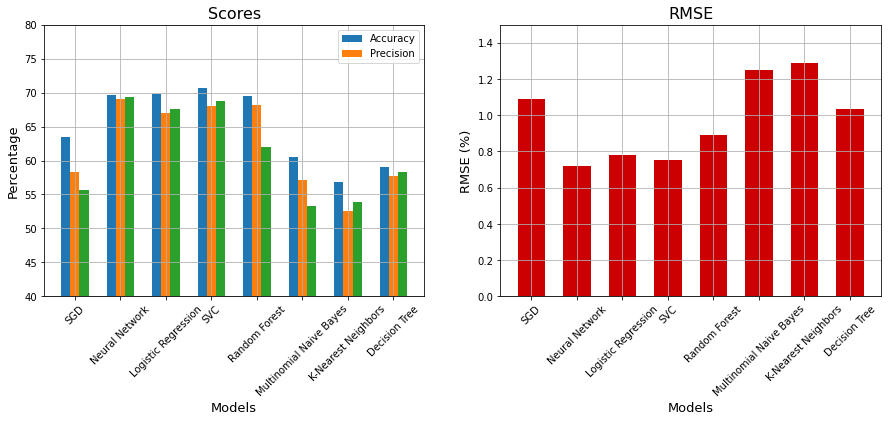

In [22]:
labels, acc, rmse , prec, f1 = zip(*all_models)
xs = np.arange(len(labels)) 
width = 0.2

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].set_title('Scores', fontsize=16)
ax[0].set(ylim=[40, 80])
ax[0].set_xlabel('Models', fontsize=13)
ax[0].set_ylabel('Percentage', fontsize=13)
ax[0].set_xticklabels(labels, rotation=45)
ax[0].set_xticks(xs)

ax[0].bar(xs-width, acc, width, label="Accuracy")


ax[0].bar(xs, prec, width, label="Precision")
ax[0].legend()

ax[0].bar(xs+width, f1, width, label="F1-Score")
ax[0].grid(clip_on=False)

width = 0.6
ax[1].set_title('RMSE', fontsize=16)
ax[1].set(ylim=[0, 1.5])
ax[1].set_xlabel('Models', fontsize=13)
ax[1].set_ylabel('RMSE (%)', fontsize=13)
ax[1].set_xticklabels(labels, rotation=45)
ax[1].set_xticks(xs)

ax[1].bar(xs, rmse, width, label="RMSE" , color="#CC0000")
ax[1].grid(clip_on=False)

